## CSE 8803: Brain-inspired Machine Intelligence

### Lab 3: Biologically Plausible Learning Rules in the Brain

Objectives:
- Unsupervised learning rules
  - Hebbian learning and Oja's rule
  - Spike-timing dependent plasticity (STDP)
- Normative models of synaptic plasticity
  - Weight perturbation
  - Node perturbation
  - Feedback alignment
  - Kolen-Pollack
- After-class questions (15 points)
  - Oja's rule and Principal Component Analysis (3 points)
  - Causality detection in STDP (3 points)
  - Assessing the variance and bias of the learning algorithms
    - Empirical demonstration of variances of weight perturbation, node perturbation, and backpropagation using Signal-to-Noise Ratio (3 points)
    - Cosine Similarity between backpropagation, feedback alignment, and Kolen-Pollack (3 points)
  - Randomness of matrix $\mathbf{B}$ in Feedback Alignment (3 points)

### Part 1: Unsupervised learning rules

#### Hebbian learning and Oja's rule

Oja's Rule is a simple but powerful linear learning rule for updating the weights in a neural network. It's an extension of the basic Hebbian learning principle, often summarized as "cells that fire together, wire together," but with an important modification to ensure stability and prevent unbounded growth of the weight vector.

In its most basic form, Oja's Rule can be expressed as:
$$
\Delta \mathbf{w} = \alpha (\mathbf{x}y - y^2 \mathbf{w})
$$

Under Oja's rule, the weight vector of the neuron converges to the eigenvector of the covariance matrix of the input data associated with the largest eigenvalue. This is exactly the first principal component as identified in PCA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate random input data, apply Oja's rule, and visualize learned weights

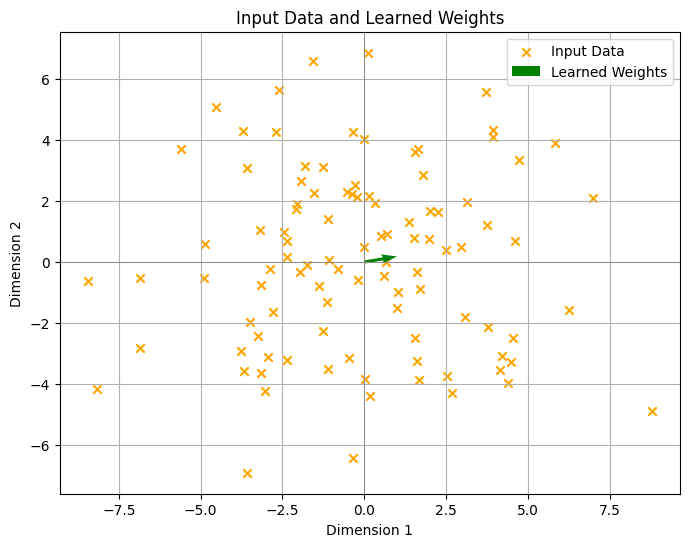

In [2]:
# generate synthetic data
np.random.seed(12345)
X = np.random.normal(0, 3, (100, 2))
X += np.random.normal(0, 1, (100, 2))  # Add some noise

# simulate Oja's Rule
def oja_rule(data, epochs, eta):
    w = np.random.rand(2)
    for _ in range(epochs):
        for x in data:
            y = np.dot(w, x)
            dw = eta * (x * y - (y**2) * w)
            w += dw
    return w

learned_weights_vector = oja_rule(X, 500, 0.01)

# plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='orange', marker='x', label='Input Data')
plt.quiver(0, 0, learned_weights_vector[0], learned_weights_vector[1], angles='xy', scale_units='xy', scale=1, color='green', width=0.005, label='Learned Weights')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.title('Input Data and Learned Weights')
plt.show()

#### Spike-timing dependent plasticity (STDP)

In this section, we will focus on building a model of a synapse in which its synaptic strength changes as a function of the relative timing (i.e., time difference) between the spikes of the presynaptic and postsynaptic neurons, respectively.

In [3]:
import time

Plotting functions

In [4]:
def my_raster_plot(range_t, spike_train, n):
    """Generates poisson trains

    Args:
      range_t     : time sequence
      spike_train : binary spike trains, with shape (N, Lt)
      n           : number of Poisson trains plot

    Returns:
      Raster_plot of the spike train
    """

    # Find the number of all the spike trains
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
        print('The number n exceeds the size of spike trains')
        print('The number n is set to be the size of spike trains')
        n = N

    # Raster plot
    i = 0
    while i <= n:
        if spike_train[i, :].sum() > 0.:
            t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
            plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n + 0.5])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.show()


def my_example_P(pre_spike_train_ex, pars, P):
    """Generates two plots (raster plot and LTP vs time plot)

    Args:
      pre_spike_train_ex     : spike-train
      pars : dictionary with the parameters
      P : LTP ratio

    Returns:
      my_example_P returns a rastert plot (top),
      and a LTP ratio across time (bottom)
    """
    spT = pre_spike_train_ex
    plt.figure(figsize=(7, 6))
    plt.subplot(211)
    color_set = ['red', 'blue', 'black', 'orange', 'cyan']
    for i in range(spT.shape[0]):
        t_sp = pars['range_t'][spT[i, :] > 0.5]   # spike times
        plt.plot(t_sp, i*np.ones(len(t_sp)), '|',
                color=color_set[i],
                ms=10, markeredgewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.xlim(0, 200)

    plt.subplot(212)
    for k in range(5):
        plt.plot(pars['range_t'], P[k, :], color=color_set[k], lw=1.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('P(t)')
    plt.xlim(0, 200)

    plt.tight_layout()
    plt.show()


def mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW):
    plt.figure()
    plt.plot([-5 * tau_stdp, 5 * tau_stdp], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

    plt.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'ro')
    plt.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'bo')

    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
    plt.ylabel(r'$\Delta$W', fontsize=12)
    plt.title('Biphasic STDP', fontsize=12, fontweight='bold')
    plt.show()

Helper functions

In [5]:
def default_pars_STDP(**kwargs):
    pars = {}

    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['V_init'] = -65.   # initial potential [mV]
    pars['V_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)

    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.                   # STDP time constant [ms]

    # simulation parameters
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]

    # external parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

    return pars


def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains

    Args:
      pars            : parameter dictionary
      rate            : noise amplitute [Hz]
      n               : number of Poisson trains
      myseed          : random seed. int or boolean

    Returns:
      pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)
    """

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

The instantaneous change in weights of STDP is given by:
$$
\
\Delta W =
\begin{cases}
A_+ e^{\frac{t_{\text{pre}} - t_{\text{post}}}{\tau_+}}, & \text{if } t_{\text{post}} > t_{\text{pre}} \\
-A_- e^{-\frac{t_{\text{pre}} - t_{\text{post}}}{\tau_-}}, & \text{if } t_{\text{post}} < t_{\text{pre}}
\end{cases}
\
$$

where $\Delta W$ denotes the change in the synaptic weight, $A_+$ and $A_-$ determine the maximum amount of synaptic modification (which occurs when the timing difference between presynaptic and postsynaptic spikes is close to zero), $\tau_+$ and $\tau_-$ determine the ranges of pre-to-postsynaptic interspike intervals over which synaptic strengthening or weakening occurs. Thus, $\Delta W > 0$ means that postsynaptic neuron spikes after the presynaptic neuron.

This model captures the phenomena that repeated occurrences of presynaptic spikes within a few milliseconds before postsynaptic action potentials lead to long-term potentiation (LTP) of the synapse, whereas repeated occurrences of presynaptic spikes after the postsynaptic ones lead to long-term depression (LTD) of the same synapse.

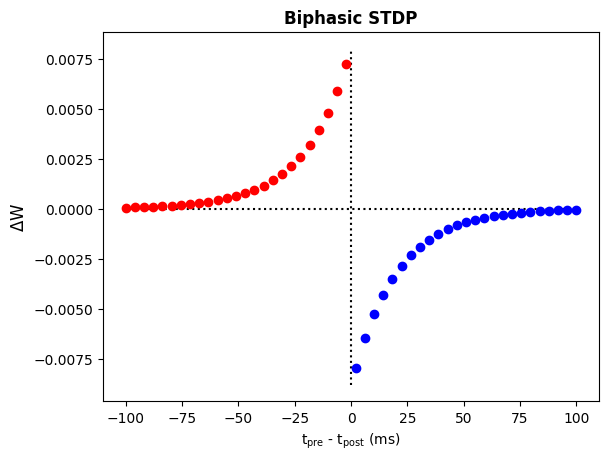

In [6]:
def Delta_W(pars, A_plus, A_minus, tau_stdp):
    """
    Plot STDP biphasic exponential decaying function

    Args:
      pars       : parameter dictionary
      A_plus     : (float) maximum amount of synaptic modification
                  which occurs when the timing difference between pre- and
                  post-synaptic spikes is positive
      A_minus    : (float) maximum amount of synaptic modification
                  which occurs when the timing difference between pre- and
                  post-synaptic spikes is negative
      tau_stdp   : the ranges of pre-to-postsynaptic interspike intervals
                  over which synaptic strengthening or weakening occurs

    Returns:
      dW         : instantaneous change in weights
    """
    # STDP change
    dW = np.zeros(len(time_diff))
    # TODO: add your implementation here.
    # Calculate dW for LTP
    # \Delta W = A+ * exp((t_pre - t_post) / \tau+)
    dW[time_diff <= 0] = A_plus * np.exp(time_diff[time_diff <= 0] / tau_stdp)
    # Calculate dW for LTD
    # \Delta W = -A_ * exp(-(t_pre - t_post) / \tau-)
    dW[time_diff > 0] = -A_minus * np.exp(-time_diff[time_diff > 0] / tau_stdp)

    return dW


pars = default_pars_STDP()
# Get parameters
A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
# pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 50)

dW = Delta_W(pars, A_plus, A_minus, tau_stdp)
mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW)

Since a neuron will receive numerous presynaptic spike inputs, in order to implement STDP by taking into account different synapses, we first have to keep track of the pre- and postsynaptic spike times throughout the simulation.

For each postsynaptic neuron, $\tau_- \frac{dM}{dt} = -M$. And $M(t) = M(t) - A_-$ whenever the postsynaptic neuron spikes. This way $M(t)$ tracks the number of postsynaptic spikes over the timescale $\tau_-$.

Similarly, whenever there is spike on the presynaptic neuron, $P(t) = P(t) + A_+$. Note that $M(t)$ is always negative, and $P(t)$ is always positive. $M$ is used to induce LTD and $P$ is to induce LTP.

Here, we will consider a scenario in which there is a single postsynaptic neuron connected to $N$ presynaptic neurons. For instance, we have one postsynaptic neuron which receives Poisson type spiking inputs from five presynaptic neurons. We can simulate $P$ for each one of the presynaptic neurons.

Similar to the dynamics of the membrane potential in the LIF model, in a time step $dt$, $P(t)$ will decrease by an amount of $\frac{dt}{\tau_+}P(t)$. Whereas, if a presynaptic spike arrives, $P(t)$ will instantaneously increase by an amount of $A_+$. Therefore,

$$
dP = -\frac{dt}{\tau_+}P(t) + A_+ \cdot \text{spornot}[t + dt]
$$

where the $\text{spornot}$ is a binary variable.

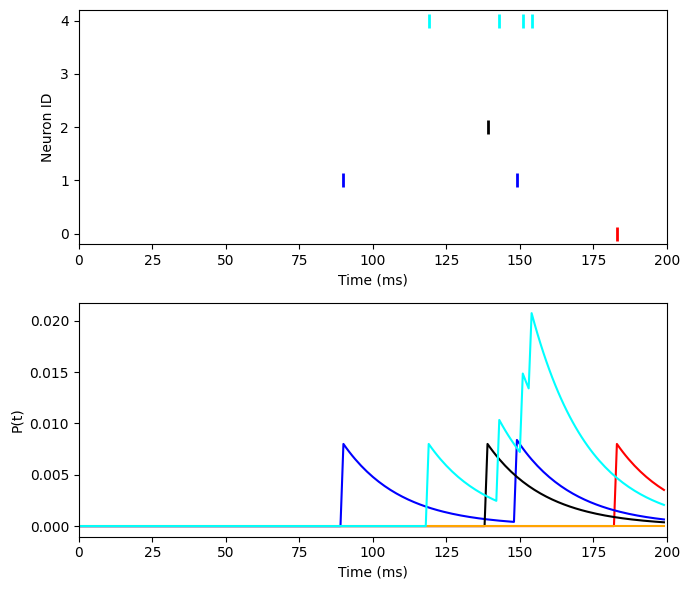

In [7]:
def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes

    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : binary spike train input from
                          presynaptic excitatory neuron

    Returns:
      P                  : LTP ratio
    """

    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
        # TODO: add your implementation here.
        # Calculate the delta increment dP
        # dP = - dt / tau * P(t) + A+ * sp_or_not[t + dt]
        dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
        # Update P
        P[:, it + 1] = P[:, it] + dP

    return P


pars = default_pars_STDP(T=200., dt=1.)
# shape: [5, 200]
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=2020)
P = generate_P(pars, pre_spike_train_ex)
my_example_P(pre_spike_train_ex, pars, P)

Finally, to implement STDP in spiking networks, we will change the value of the peak synaptic conductance based on the presynaptic and postsynaptic timing, thus using the variables $P(t)$ and $M(t)$.

Each synapse $i$ has its own peak synaptic conductance $(\overline{g}_i)$, which may vary between $[0, {\overline{g}}_{\text{max}}]$, and will be modified depending on the presynaptic and postsynaptic timing.

- When the $i_{th}$ presynaptic neuron elicits a spike, its corresponding peak conductance is updated according to the following equation:
  $$
  \overline{g}_i = \overline{g}_i + M(t){\overline{g}}_{\text{max}}
  $$
  Note that, $M(t)$ tracks the time since the last postsynaptic potential and is always negative. Hence, if the postsynaptic neuron spikes shortly before the presynaptic neuron, the above equation shows that the peak conductance will decrease.

- When the postsynaptic neuron spikes, the peak conductance of *each synapse* is updated according to:
  $$
  \overline{g}_i = \overline{g}_i + P_i(t) \overline{g}_{\text{max}}, \; \forall i
  $$
  Note that, $P_i(t)$ tracks the time since the last spike of $i_{th}$ pre-synaptic neuron and is always positive.
  Thus, the equation given above shows that if the presynaptic neuron spikes before the postsynaptic neuron, its peak conductance will increase.

In the following exercise, we connect $N$ presynaptic neurons to a single postsynaptic neuron. We do not need to simulate the dynamics of each presynaptic neuron as we are only concerned about their spike times. So, we will generate $N$ Poisson type spikes. Here, we will assume that all these inputs are excitatory.

We need to simulate the dynamics of the postsynaptic neuron as we do not know its spike times. We model the postsynaptic neuron as an LIF neuron receiving only excitatory inputs.

$$
\tau_m \frac{dV}{dt} = -(V - E_L) - g_E(t)(V(t) - E_E)
$$
where the total excitatory synaptic conductance \(g_E(t)\) is given by:
$$
g_E(t) = \sum_{i=1}^N g_i(t)
$$

In [8]:
def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    """
    conductance-based LIF dynamics

    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron

    Returns:
      rec_spikes         : spike times
      rec_v              : mebrane potential
      gE                 : postsynaptic excitatory conductance
    """

    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_minus, tau_stdp = pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    P = generate_P(pars, pre_spike_train_ex)

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value

    # simulation
    rec_spikes = []  # recording spike times
    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1
        elif v[it] >= V_th:   # reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it] * gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref / dt

        # update the synaptic conductance
        M[it + 1] = M[it] - dt / tau_stdp * M[it]
        gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + (gE_bar_update[:, it] * pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it + 1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it + 1] < 0
        gE_bar_update[id_temp, it + 1] = 0.

        # calculate the increment of the membrane potential
        dv = (-(v[it] - V_L) - gE[it + 1] * (v[it] - VE)) * (dt / tau_m)

        # update membrane potential
        v[it + 1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, P, M, gE_bar_update

Evolution of excitatory synaptic conductance

In [9]:
pars = default_pars_STDP(T=200., dt=1.)  # Simulation duration 200 ms
pars['gE_bar'] = 0.024                   # max synaptic conductance
pars['gE_init'] = 0.024                  # initial synaptic conductance
pars['VE'] = 0.                          # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.                   # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex)

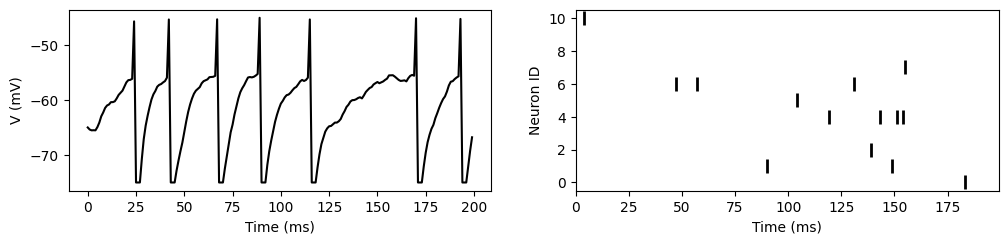

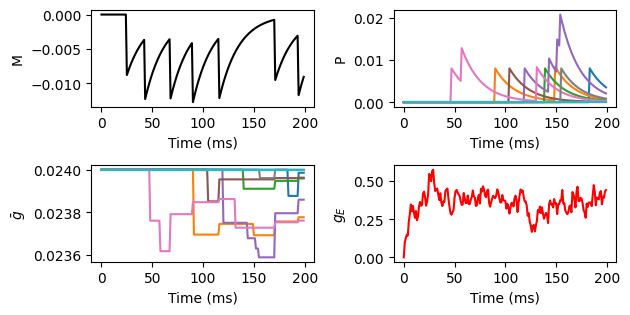

In [10]:
plt.figure(figsize=(12., 8))
plt.subplot(321)
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
    sp_num = (rec_spikes / dt).astype(int) - 1
    v[sp_num] += 10   # add artificial spikes
plt.plot(pars['range_t'], v, 'k')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')

plt.subplot(322)
# Plot the sample presynaptic spike trains
my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)

plt.subplot(323)
plt.plot(pars['range_t'], M, 'k')
plt.xlabel('Time (ms)')
plt.ylabel('M')

plt.subplot(324)
for i in range(10):
    plt.plot(pars['range_t'], P[i, :])
plt.xlabel('Time (ms)')
plt.ylabel('P')

plt.subplot(325)
for i in range(10):
    plt.plot(pars['range_t'], gE_bar_update[i, :])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\bar g$')

plt.subplot(326)
plt.plot(pars['range_t'], gE, 'r')
plt.xlabel('Time (ms)')
plt.ylabel(r'$g_E$')

plt.tight_layout()
plt.show()

How the distribution of synaptic weights evolves as a function of time

In [11]:
import ipywidgets as widgets
my_layout = widgets.Layout()

def example_LIF_STDP(inputrate=15., Tsim=120000.):
    """
    Simulation of a LIF model with STDP synapses

    Args:
      intputrate  :  The rate used for generate presynaptic spike trains
      Tsim        :  Total simulation time

    output:
      Interactive demo, Visualization of synaptic weights
    """

    pars = default_pars_STDP(T=Tsim,  dt=1.)
    pars['gE_bar'] = 0.024
    pars['gE_init'] = 0.014  # initial synaptic conductance
    pars['VE'] = 0.          # [mV]
    pars['tau_syn_E'] = 5.   # [ms]

    starttime = time.perf_counter()
    pre_spike_train_ex = Poisson_generator(pars, rate=inputrate, n=300,
                                          myseed=2020)  # generate Poisson trains
    v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars,
                                                              pre_spike_train_ex)  # simulate LIF neuron with STDP
    gbar_norm = gE_bar_update/pars['gE_bar']  # calculate the ratio of the synaptic conductance
    endtime = time.perf_counter()
    timecost = (endtime - starttime) / 60.

    print('Total simulation time is %.3f min' % timecost)

    my_layout.width = '620px'

    @widgets.interact(
        sample_time=widgets.FloatSlider(0.5, min=0., max=1., step=0.1,
                                        layout=my_layout)
    )

    def my_visual_STDP_distribution(sample_time=0.0):
        sample_time = int(sample_time * pars['range_t'].size) - 1
        sample_time = sample_time * (sample_time > 0)

        plt.figure(figsize=(8, 8))
        ax1 = plt.subplot(211)
        for i in range(50):
            ax1.plot(pars['range_t'][::1000] / 1000., gE_bar_update[i, ::1000], lw=1., alpha=0.7)

        ax1.axvline(1e-3 * pars['range_t'][sample_time], 0., 1., color='k', ls='--')
        ax1.set_ylim(0, 0.025)
        ax1.set_xlim(-2, 122)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel(r'$\bar{g}$')

        bins = np.arange(-.05, 1.05, .05)
        g_dis, _ = np.histogram(gbar_norm[:, sample_time], bins)
        ax2 = plt.subplot(212)
        ax2.bar(bins[1:], g_dis, color='b', alpha=0.5, width=0.05)
        ax2.set_xlim(-0.1, 1.1)
        ax2.set_xlabel(r'$\bar{g}/g_{\mathrm{max}}$')
        ax2.set_ylabel('Number')
        ax2.set_title(('Time = %.1f s' % (1e-3 * pars['range_t'][sample_time])),
                      fontweight='bold')
        plt.show()

In [12]:
example_LIF_STDP(inputrate=15)

Total simulation time is 0.043 min


interactive(children=(FloatSlider(value=0.5, description='sample_time', layout=Layout(width='620px'), max=1.0)…

### Part 2: Normative models of synaptic plasticity

In this part, we will learn about normative models of synaptic plasticity. Normative models of synaptic plasticity are learning rules for parameters in neural networks that have two important features:

- They optimize global objective functions that define behavioral/perceptual goals for an agent.

- Unlike learning algorithms like backpropagation, they demonstrate how learning is **local**, i.e. it uses only information that could conceivably be available to a single synapse.

In this part, we will implement weight perturbation, node perturbation, feedback alignment, and Kolen-Pollack.

In [13]:
# import dependencies
import logging
from datetime import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from IPython.display import display, HTML

#### Helper functions

In [97]:
# The sigmoid activation function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    toobig = X > 500
    toosmall = X < -500
    Y[toobig] = 500
    Y[toosmall] = -500

    return 1.0 / (1.0 + np.exp(-Y))

# The ReLU activation function
def ReLU(X):
    """
    Returns the ReLU function, i.e. X if X > 0, 0 otherwise
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    neg = X < 0
    Y[neg] = 0

    return Y


# A helper function to add an "always on" unit to the inputs, let's us keep the biases in the weight matrices
def add_bias(inputs):
    """
    Append an "always on" bias unit to some inputs
    """
    return np.append(inputs, np.ones((1, inputs.shape[1])), axis=0)


# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(rng, batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.

    If the size of the data is not divisible by the batch size some samples will not be included.
    """

    # determine the total number of batches
    num_batches = int(np.floor(num_samples / batch_size))

    # get the batches (without replacement)
    return rng.choice(np.arange(num_samples), size=(num_batches, batch_size), replace=False)


# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs, targets):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """

    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0), (10, 1))).astype('float')

    # get the accuracy
    accuracy = np.sum(categories * targets) / targets.shape[1]

    return accuracy * 100.0


def calculate_cosine_similarity(grad_1, grad_2):
    """
    Calculate the cosine similarity between two gradients
    """
    # TODO: add your implementation here for Section 3.3.
    """
    $$
    C Sim(\Delta \theta_1, \Delta \theta_2) = \frac{\Delta \theta_1^T \Delta \theta_2}{\|\Delta \theta_1\|_2 \|\Delta \theta_2\|_2}
    $$
    """
    grad_dot_prods = np.diag(np.dot(grad_1, grad_2.T))
    normalizing_factor = np.linalg.norm(grad_1, axis=1) * np.linalg.norm(grad_2, axis=1)
    cosine_similarity =  grad_dot_prods / normalizing_factor
    return np.mean(cosine_similarity)

def calculate_grad_snr(grad, epsilon=1e-3):
    """
    Calculate the average SNR |mean|/std across all parameters in a gradient update
    """
    # TODO: add your implementation here for Section 3.3.
    """
    $$
    SNR(X) = \frac{|Mean(X)|}{Std(X) + \epsilon}
    $$
    """
    mean = np.average(grad)
    std = np.std(grad)
    return np.abs(mean) / (std + epsilon)
    

#### Main network class

In [98]:
# The main network class
# This will function as the parent class for our networks, which will implement different learning algorithms
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """

    # The initialization function
    def __init__(self, rng, N=100, sigma=1.0, activation='sigmoid'):
        """
        The initialization function for the MLP.

         - N is the number of hidden units
         - sigma is the Standard Deviation for initializing the weights
         - activation is the function to use for unit activity, options are 'sigmoid' and 'ReLU'
        """

        # store the variables for easy access
        self.N = N
        self.sigma = sigma
        self.activation = activation

        # initialize the weights
        self.W_h = rng.normal(scale=self.sigma, size=(self.N, 784 + 1))  # input-to-hidden weights & bias
        self.W_y = rng.normal(scale=self.sigma, size=(10, self.N + 1))  # hidden-to-output weights & bias
        self.B = rng.normal(scale=self.sigma, size=(self.N, 10))  # feedback weights

    # The non-linear activation function
    def activate(self, inputs):
        """
        Pass some inputs through the activation function.
        """
        if self.activation == 'sigmoid':
            Y = sigmoid(inputs)
        elif self.activation == 'ReLU':
            Y = ReLU(inputs)
        else:
            raise Exception("Unknown activation function")
        return Y

    # The function for performing a forward pass up through the network during inference
    def inference(self, rng, inputs, W_h=None, W_y=None, noise=0.):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """

        # load the current network weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        # calculate the hidden activities
        hidden = self.activate(np.dot(W_h, add_bias(inputs)))
        if not (noise == 0.):
            hidden += rng.normal(scale=noise, size=hidden.shape)

        # calculate the output activities
        output = self.activate(np.dot(W_y, add_bias(hidden)))

        if not (noise == 0.):
            output += rng.normal(scale=noise, size=output.shape)

        return hidden, output

    # A function for calculating the derivative of the activation function
    def act_deriv(self, activity):
        """
        Calculate the derivative of some activations with respect to the inputs
        """
        if self.activation == 'sigmoid':
            derivative = activity * (1 - activity)
        elif self.activation == 'ReLU':
            derivative = 1.0 * (activity > 1)
        else:
            raise Exception("Unknown activation function")
        return derivative

    def mse_loss_batch(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets
        """

        # do a forward sweep through the network
        if (output is None):
            (hidden, output) = self.inference(rng, inputs, W_h, W_y)
        return np.sum((targets - output) ** 2, axis=0)

    # The function for calculating the mean-squared error loss
    def mse_loss(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
        return np.mean(self.mse_loss_batch(rng, inputs, targets, W_h=W_h, W_y=W_y, output=output))

    # function for calculating perturbation updates
    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    # function for calculating gradient updates
    def gradient(self, rng, inputs, targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the gradients
        error = targets - output
        # gradient for hidden layer
        delta_W_h = np.dot(
            np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            add_bias(inputs).transpose())
        # gradient for output layer
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        raise NotImplementedError()

    # function for calculating Kolen-Pollack updates
    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        raise NotImplementedError()

    def return_grad(self, rng, inputs, targets, algorithm='backprop', eta=0., noise=1.0):
        # calculate the updates for the weights with the appropriate algorithm
        if algorithm == 'perturb':
            delta_W_h, delta_W_y = self.perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'node_perturb':
            delta_W_h, delta_W_y = self.node_perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'feedback':
            delta_W_h, delta_W_y = self.feedback(rng, inputs, targets)
        elif algorithm == 'kolepoll':
            delta_W_h, delta_W_y = self.kolepoll(rng, inputs, targets, eta_back=eta)
        else:
            delta_W_h, delta_W_y = self.gradient(rng, inputs, targets)

        return delta_W_h, delta_W_y

    # function for updating the network
    def update(self, rng, inputs, targets, algorithm='backprop', eta=0.01, noise=1.0):
        """
        Updates the synaptic weights (and unit biases) using the given algorithm, options are:

        - 'backprop': backpropagation-of-error (default)
        - 'perturb' : weight perturbation (use noise with SD as given)
        - 'feedback': feedback alignment
        - 'kolepoll': Kolen-Pollack
        """

        delta_W_h, delta_W_y = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=eta, noise=noise)

        # do the updates
        self.W_h += eta * delta_W_h
        self.W_y += eta * delta_W_y

    # train the network using the update functions
    def train(self, rng, images, labels, num_epochs, test_images, test_labels, learning_rate=0.01, batch_size=20, \
              algorithm='backprop', noise=1.0, report=False, report_rate=10):
        """
        Trains the network with algorithm in batches for the given number of epochs on the data provided.

        Uses batches with size as indicated by batch_size and given learning rate.

        For perturbation methods, uses SD of noise as given.

        Categorization accuracy on a test set is also calculated.

        Prints a message every report_rate epochs if requested.

        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """

        # provide an output message
        if report:
            print("Training starting...")

        # make batches from the data
        batches = create_batches(rng, batch_size, images.shape[1])

        # create arrays to store loss and accuracy values
        losses = np.zeros((num_epochs * batches.shape[0],))
        accuracy = np.zeros((num_epochs,))
        cosine_similarity = np.zeros((num_epochs,))

        # estimate the gradient SNR on the test set
        grad = np.zeros((test_images.shape[1], *self.W_h.shape))
        for t in range(test_images.shape[1]):
            inputs = test_images[:, [t]]
            targets = test_labels[:, [t]]
            grad[t, ...], _ = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=0., noise=noise)
        snr = calculate_grad_snr(grad)
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):

            # step through each batch
            for b in range(batches.shape[0]):
                # get the inputs and targets for this batch
                inputs = images[:, batches[b, :]]
                targets = labels[:, batches[b, :]]

                # calculate the current loss
                losses[update_counter] = self.mse_loss(rng, inputs, targets)

                # update the weights
                self.update(rng, inputs, targets, eta=learning_rate, algorithm=algorithm, noise=noise)
                update_counter += 1
                if update_counter % 50 == 0:
                    print("iterations: ", update_counter)

            # calculate the current test accuracy
            (testhid, testout) = self.inference(rng, test_images)
            accuracy[epoch] = calculate_accuracy(testout, test_labels)
            grad_test, _ = self.return_grad(rng, test_images, test_labels, algorithm=algorithm, eta=0., noise=noise)
            grad_bp, _ = self.return_grad(rng, test_images, test_labels, algorithm='backprop', eta=0., noise=noise)
            cosine_similarity[epoch] = calculate_cosine_similarity(grad_test, grad_bp)

            # print an output message every 10 epochs
            if report and np.mod(epoch + 1, report_rate) == 0:
                print("...completed ", epoch + 1,
                      " epochs of training. Current loss: ", round(losses[update_counter - 1], 2), ".")

        # provide an output message
        if report:
            print("Training complete.")

        return (losses, accuracy, cosine_similarity, snr)

#### Download MNIST dataset

100%|██████████| 4542/4542 [00:00<00:00, 2491567.98it/s]


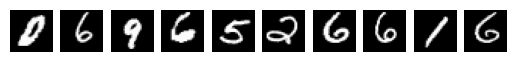

In [17]:
import contextlib
import io
import pandas as pd
import requests
import os
import hashlib


with contextlib.redirect_stdout(io.StringIO()):
    # Load the MNIST dataset, 50K training images, 10K validation, 10K testing
    train_set = datasets.MNIST('./', transform=transforms.ToTensor(), train=True, download=True)
    test_set = datasets.MNIST('./', transform=transforms.ToTensor(), train=False, download=True)

    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_images = train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(test_set.targets, num_classes=10).numpy().T

    full_train_images = None
    full_train_labels = None
    train_set = None
    test_set = None

# Plot some example images to make sure everything is loaded in properly
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(train_images[:,c].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

#### Weight Perturbation

In this first section, we will be implementing the Weight Perturbation algorithm.

Suppose that we have some loss function, $\mathscr{L}(\Delta \mathbf{W})$, which we would like to minimize by making some change in our synaptic weights, $\Delta W$. The most natural way to decrease the loss would be to perform gradient descent; however, it is not reasonable to assume that a synapse in the brain could perform analytic gradient calculations for general loss functions, which may depend on the activity of many downstream neurons. Biological systems could solve this problem by approximating the gradient of the loss, which could be accomplished in many ways.

To start, we will provide the weight perturbation update. We will first add noise to our weights, using $\mathbf{W}' = \mathbf{W} + \Psi$, where $\Psi \sim \mathscr{N}(0, \sigma^2)$. We take as our update:

$$
\Delta \mathbf{W} = -\eta \mathbb{E}_\mathbf{\Psi} \left[ \left( \mathscr{L}(\mathbf{\Psi}) - \mathscr{L}(0) \right) \frac{(\mathbf{W'} - \mathbf{W})}{\sigma^2} \right].
$$

It can be proved that this this update is an approximation of the loss gradient by using first-order Taylor expansion.

In [18]:
class WeightPerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through weight perturbation
    """

    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        # get the random perturbations
        # W' - W
        delta_W_h = rng.normal(scale=noise, size=self.W_h.shape)
        delta_W_y = rng.normal(scale=noise, size=self.W_y.shape)

        # calculate the loss with and without the perturbations
        loss_now = self.mse_loss(rng, inputs, targets)
        loss_per = self.mse_loss(rng, inputs, targets, self.W_h + delta_W_h, self.W_y + delta_W_y)

        # TODO: add your implementation here.
        delta_loss = loss_now - loss_per  # L(psi) - L(0)
        W_h_update = delta_loss * delta_W_h / noise ** 2  # delta_loss * (W' - W) / sigma^2
        W_y_update = delta_loss * delta_W_y / noise ** 2  # delta_loss * (W' - W) / sigma^2
        return W_h_update, W_y_update

Now, we will train an MLP on MNIST with weight perturbation to estimate the gradient. The MLP consists of:
- An input layer with 784 units
- A hidden layer with 500 units
- An output layer with 10 units

We will use the mean-squared error loss on the one-hot encoded labels.

In [19]:
# hyperparameters
numhidden = 500
batchsize = 200
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 4  # change from 2 to 4 for better convergence
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

In [20]:
# Train WeightPerturbMLP
rng_wp = np.random.default_rng(seed=seed)
losses_perturb = np.zeros((numupdates,))
accuracy_perturb = np.zeros((numepochs,))

# select 1000 random images to test the accuracy on
indices = rng_wp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# instantiate a WeightPerturbMLP network and train it
netperturb = WeightPerturbMLP(rng_wp, numhidden, sigma=initweight, activation=activation)
(losses_perturb[:], accuracy_perturb[:], _, _) = \
    netperturb.train(rng_wp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                     learning_rate=learnrate, batch_size=batchsize, algorithm='perturb', noise=noise, \
                     report=report, report_rate=rep_rate)

# # save metrics for plots
losses_weight_perturbation_solution = losses_perturb
accuracy_weight_perturbation_solution = accuracy_perturb

Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.94 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.93 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.95 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.95 .
Training complete.


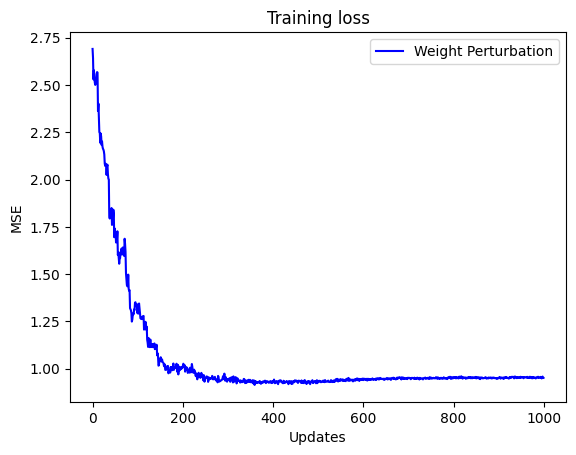

In [54]:
# # plot performance over time
plt.plot(losses_weight_perturbation_solution, label="Weight Perturbation", color='b')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

#### Node Perturbation

While we can get an unbiased derivative approximation based solely on perturbations of the weights, we will show later on that this is actually a very inefficient method, because it requires averaging out $MN$ noise sources, where $M$ is the dimension of the input $\mathbf{x}$ and $N$ is the dimension of the hidden activity $\mathbf{r}$.

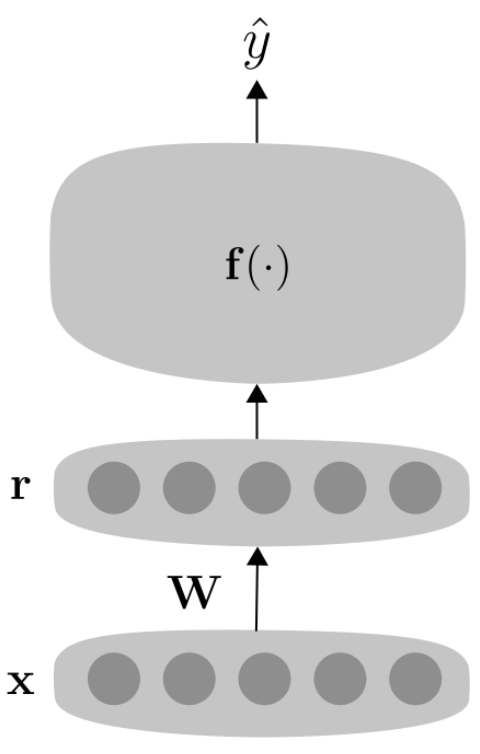

If we add noise at the level of the hidden units $\mathbf{r} = \mathbf{W}\mathbf{x}$, we will only have to average over $N$ noise sources. To do this, we can use the following update, taking $\mathbf{r}' = \mathbf{r} + \mathbf{\xi}$, where $\mathbf{\xi} \sim \mathscr{N}(0, \sigma^2)$:

$$
\Delta \mathbf{W} = -\eta \mathbb{E}_\mathbf{\xi} \left[ \left( \mathscr{L}(\mathbf{\xi}) - \mathscr{L}(0) \right) \frac{(\mathbf{r'} - \mathbf{r}) \mathbf{x}^T}{\sigma^2} \right].
$$


In [22]:
class NodePerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through node perturbation
    """

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        # r
        hidden, output = self.inference(rng, inputs)
        # r'
        hidden_p, output_p = self.inference(rng, inputs, noise=noise)

        loss_now = self.mse_loss_batch(rng, inputs, targets, output=output)
        loss_per = self.mse_loss_batch(rng, inputs, targets, output=output_p)
        delta_loss = loss_now - loss_per  # L(xi) - L(0)

        # delta_loss * (r' - r) / sigma^2 * x^T
        hidden_update = np.mean(
            delta_loss * (((hidden_p - hidden) / noise ** 2)[:, None, :] * add_bias(inputs)[None, :, :]), axis=2)
        output_update = np.mean(
            delta_loss * (((output_p - output) / noise ** 2)[:, None, :] * add_bias(hidden_p)[None, :, :]), axis=2)

        return (hidden_update, output_update)

In [23]:
# Train NodePerturbMLP
losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
netnodeperturb = NodePerturbMLP(rng_np, numhidden, sigma=initweight, activation=activation)
(losses_node_perturb[:], accuracy_node_perturb[:], _, _) = \
    netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                        learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                        report=report, report_rate=rep_rate)

# save metrics for plots
losses_node_perturbation_solution = losses_node_perturb
accuracy_node_perturbation_solution = accuracy_node_perturb

Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.89 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.85 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.81 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.77 .
Training complete.


Train a network with Backpropagation for comparison

In [29]:
# set the random seed to the current time
rng_bp = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
cosine_sim_backprop = np.zeros((numepochs,))

# create a network and train it using backprop
netbackprop = MLP(rng_bp, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], _, _) = \
    netbackprop.train(rng_bp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

# save metrics for plots
losses_backpropagation_solution = losses_backprop
accuracy_backpropagation_solution = accuracy_backprop

Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.43 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.31 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.26 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.24 .
Training complete.


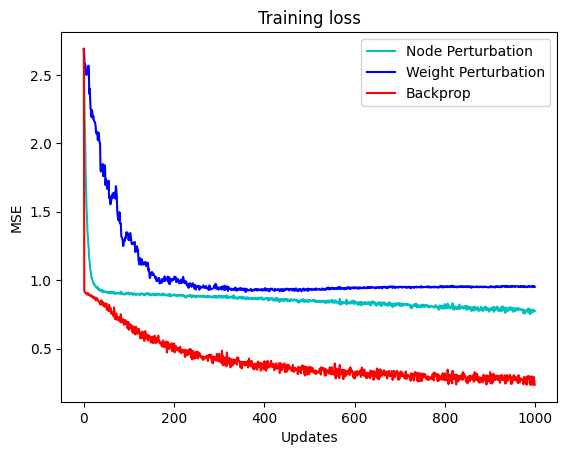

In [30]:
# plot performance over time
plt.plot(losses_node_perturbation_solution, label="Node Perturbation", color='c') #pre-saved history of loss
plt.plot(losses_weight_perturbation_solution, label="Weight Perturbation", color='b') #pre-saved history of loss
plt.plot(losses_backpropagation_solution, label="Backprop", color='r')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

#### Feedback Alignment

Unlike weight and node perturbation, feedback alignment provides a mechanism whereby individual neurons can receive targeted error signals.

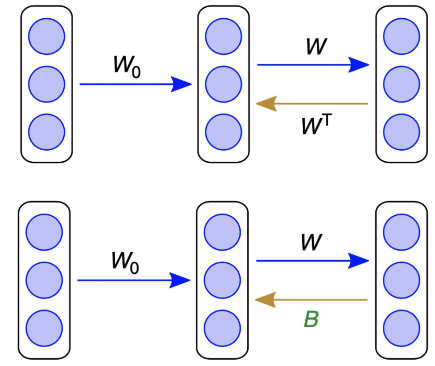

Feedback alignment replaces $\mathbf{W}_{out}^T$ with a random matrix $\mathbf{B}$. This resolves the ‘weight transport’ problem, because the feedback weights are no longer the same as the feedforward weights. However, by replacing $\mathbf{W}_{out}^T$ with $\mathbf{B}$, we are no longer calculating an accurate gradient. Interestingly, we will see empirically that this replacement still produces reasonably good gradient estimates, though it still introduces bias.

In [24]:
class FeedbackAlignmentMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Feedback Alignment algorithm
    """

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # TODO: add your implementation here.
        error = targets - output

        # recall that for Backprop, the gradient is
        # delta_W_h = np.dot(
            # np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            # add_bias(inputs).transpose())
        # delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())
        # here we replace self.W_y[:, :-1].transpose() with self.B

        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden),
                           add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

In [25]:
# define hyperparameters
numhidden  = 500
batchsize  = 200
initweight = 0.1
learnrate  = 0.001
noise      = 0.1
numepochs  = 4
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report     = True
rep_rate   = 1
seed = 12345

In [26]:
# Train FeedbackAlignmentMLP
rng_fa = np.random.default_rng(seed=seed)

losses_feedback = np.zeros((numupdates,))
accuracy_feedback = np.zeros((numepochs,))
cosine_sim_feedback = np.zeros((numepochs,))

# select 1000 random images to test the accuracy on
indices = rng_fa.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netfeedback = FeedbackAlignmentMLP(rng_fa, numhidden, sigma=initweight, activation=activation)
(losses_feedback[:], accuracy_feedback[:], _, _) = \
    netfeedback.train(rng_fa, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='feedback', noise=noise, \
                      report=report, report_rate=rep_rate)

# save metrics for plots
losses_feedback_alignment_solution = losses_feedback
accuracy_feedback_alignment_solution = accuracy_feedback

Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.59 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.41 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.33 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.29 .
Training complete.


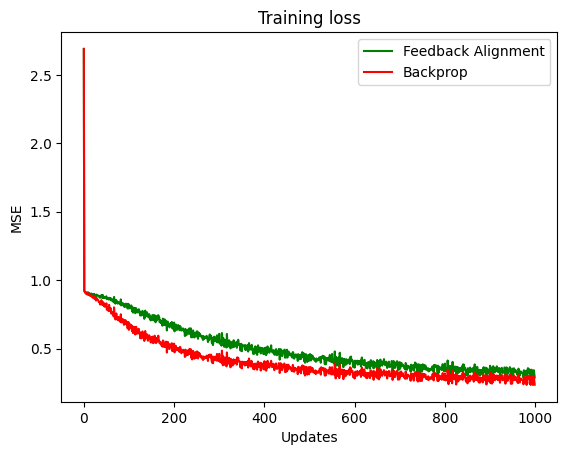

In [31]:
# plot performance over time
plt.plot(losses_feedback_alignment_solution, label="Feedback Alignment", color='g')
plt.plot(losses_backpropagation_solution, label="Backprop", color='r')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

#### Kolen-Pollack

With feedback alignment, we showed that a random feedback matrix, $\mathbf{B}$, can align the weights to propagate an approximated error. We will now show a biologically plausible approach to modify $\mathbf{B}$, such that over learning, $\mathbf{B}$ and $\mathbf{W}_{out}^T$ become equal.

The plausible learning rule for the backward weights is

$$
\Delta \mathbf{B} = -\eta \mathbf{h}\mathbf{e}^T - \lambda \mathbf{B}
$$
$$
\mathbf{B} = \mathbf{B} + \eta_{back} \Delta \mathbf{B}
$$
$$
\Delta \mathbf{W}_{out} = -\eta \mathbf{e}\mathbf{h}^T - \lambda \mathbf{W}_{out}
$$

In [32]:
class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Pollack learning
        """

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        # similar to feedback alignment, we replace self.W_y[:, :-1].transpose() with self.B
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        # TODO: add your implementation here.
        delta_err = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_B = delta_err[:, :-1].transpose() - 0.1 * self.B
        self.B += eta_back * delta_B
        return (delta_W_h, delta_W_y)

In [33]:
# Train KolenPollackMLP
rng_kp = np.random.default_rng(seed=seed)

losses_kolepoll = np.zeros((numupdates,))
accuracy_kolepoll = np.zeros((numepochs,))
cosine_sim_kolepoll = np.zeros((numepochs,))
# select 1000 random images to test the accuracy on
indices = rng_kp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netkolepoll = KolenPollackMLP(rng_kp, numhidden, sigma=initweight, activation=activation)
(losses_kolepoll[:], accuracy_kolepoll[:], cosine_sim_kolepoll[:], _) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

# save metrics for plots
losses_kolen_pollack_solution = losses_kolepoll
accuracy_kolen_pollack_solution = accuracy_kolepoll
cosine_similarity_kolen_pollack_solution = cosine_sim_kolepoll

Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.57 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.38 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.3 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.26 .
Training complete.


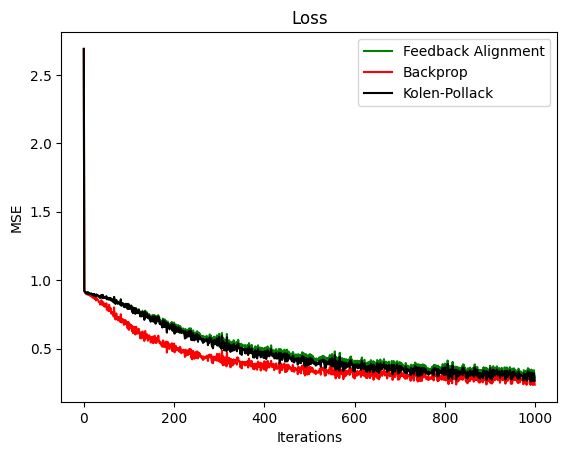

In [115]:
# plot performance over time
plt.plot(losses_feedback_alignment_solution, label="Feedback Alignment", color='g')
plt.plot(losses_backpropagation_solution, label="Backprop", color='r')
plt.plot(losses_kolen_pollack_solution, label="Kolen-Pollack", color='k')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

##### Finally, let’s show that these improvements in the alignment between the backprop gradient estimates and the various local estimates correlate with the accuracy of the classification on MNIST.

Text(0.5, 1.0, 'Accuracy over epochs')

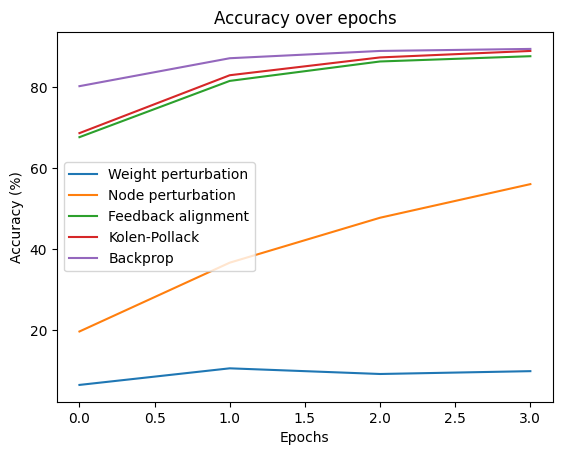

In [35]:
plt.plot(accuracy_weight_perturbation_solution)
plt.plot(accuracy_node_perturbation_solution)
plt.plot(accuracy_feedback_alignment_solution)
plt.plot(accuracy_kolen_pollack_solution)
plt.plot(accuracy_backpropagation_solution)
plt.legend(['Weight perturbation', 'Node perturbation', 'Feedback alignment', 'Kolen-Pollack', 'Backprop'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')

### Part 3: After-class questions (15 points)

For each section, please share your findings and analysis in your report.

#### 3.1 Oja's rule and Principal Component Analysis (3 points)

In part 1, we visualize the learned weights using Oja's rule. Code is provided to you below. Now, compute the principle component of $X$ using any available packages you prefer and plot it on the same graph. Demonstrate the correlation between the theoretically derived principal component and the empirically learned weights.

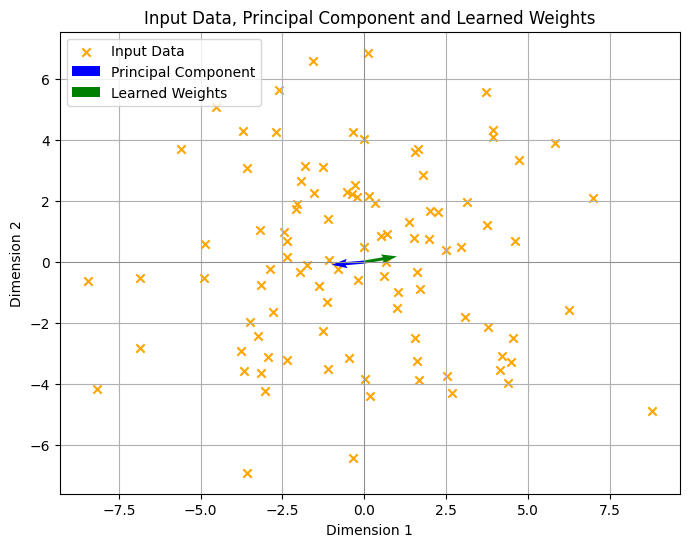

In [120]:
# generate synthetic data
np.random.seed(12345)
X = np.random.normal(0, 3, (100, 2))
X += np.random.normal(0, 1, (100, 2))  # Add some noise

# simulate Oja's Rule
def oja_rule(data, epochs, eta):
    w = np.random.rand(2)
    for _ in range(epochs):
        for x in data:
            y = np.dot(w, x)
            dw = eta * (x * y - (y**2) * w)
            w += dw
    return w

learned_weights_vector = oja_rule(X, 500, 0.01)

# TODO: add your implementation here for principal component.
cov = np.cov(X, rowvar=False)
V, s, Vt = np.linalg.svd(cov)
principal_component = V[:, 0]

# plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='orange', marker='x', label='Input Data')

# TODO: add your implementation here.
plt.quiver(0, 0, principal_component[0], principal_component[1], angles='xy', scale_units='xy', scale=1, color='blue', width=0.005, label='Principal Component')

plt.quiver(0, 0, learned_weights_vector[0], learned_weights_vector[1], angles='xy', scale_units='xy', scale=1, color='green', width=0.005, label='Learned Weights')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.title('Input Data, Principal Component and Learned Weights')
plt.savefig('images/oja_rule.png')
plt.show()

#### 3.2 Causality detection in STDP (3 points)

$$
\
\Delta W =
\begin{cases}
A_+ e^{\frac{t_{\text{pre}} - t_{\text{post}}}{\tau_+}}, & \text{if } t_{\text{post}} > t_{\text{pre}} \\
-A_- e^{-\frac{t_{\text{pre}} - t_{\text{post}}}{\tau_-}}, & \text{if } t_{\text{post}} < t_{\text{pre}}
\end{cases}
\
$$

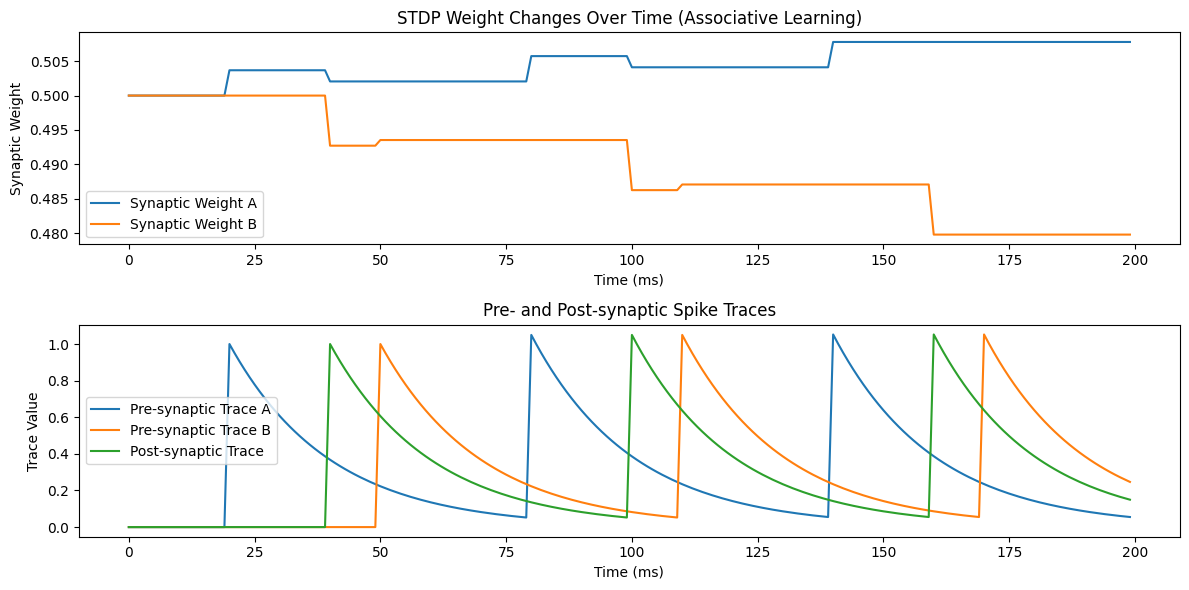

In [121]:
# Associative Learning with Two Pre-synaptic Neurons
# STDP parameters
tau_pre = 20.0  # Time constant for pre-synaptic trace decay (ms)
tau_post = 20.0  # Time constant for post-synaptic trace decay (ms)
A_plus = 0.01  # LTP factor (positive change in weight)
A_minus = 0.012  # LTD factor (negative change in weight)

# Define time step and total simulation time
dt = 1.0  # Time step (ms)
T = 200  # Total time (ms)

# Generate spike times for two pre-synaptic neurons and one post-synaptic neuron
pre_A_spike_times = np.array([20, 80, 140])  # Neuron A spike times (ms)
pre_B_spike_times = np.array([50, 110, 170])  # Neuron B spike times (ms)
post_spike_times = np.array([40, 100, 160])  # Post-synaptic neuron spike times (ms)

# Initialize synaptic weights
weight_A = 0.5  # Initial synaptic weight for Neuron A
weight_B = 0.5  # Initial synaptic weight for Neuron B
time = np.arange(0, T, dt)
weight_A_history = np.zeros(len(time))  # Store weight changes for Neuron A
weight_B_history = np.zeros(len(time))  # Store weight changes for Neuron B

# Traces for pre- and post-synaptic neurons
pre_A_trace = np.zeros(len(time))
pre_B_trace = np.zeros(len(time))
post_trace = np.zeros(len(time))

# Function to update synaptic weight using STDP rule
def update_weights(pre_spike, post_spike, current_weight, A_plus, A_minus):
    delta_t = pre_spike - post_spike
    # TODO: add your implementation here for LTP and LTD separately.
    if delta_t > 0:
        return current_weight - A_minus * np.exp(-delta_t / tau_post)
    else:
        return current_weight + A_plus * np.exp(delta_t / tau_pre)

# Simulate associative learning via STDP
for t in range(len(time)):
    # Update traces based on spike timing
    if t in pre_A_spike_times:
        pre_A_trace[t] = 1.0
    if t in pre_B_spike_times:
        pre_B_trace[t] = 1.0
    if t in post_spike_times:
        post_trace[t] = 1.0

    # Decay pre- and post-synaptic traces
    if t > 0:
        # decay by exp^{-dt / tau}
        pre_A_trace[t] += pre_A_trace[t - 1] * np.exp(-dt / tau_pre)
        pre_B_trace[t] += pre_B_trace[t - 1] * np.exp(-dt / tau_pre)
        post_trace[t] += post_trace[t - 1] * np.exp(-dt / tau_post)

    # Apply STDP for Neuron A (associative learning)
    if t in pre_A_spike_times:
        for post_spike_time in post_spike_times:
            if post_spike_time > t:  # Pre before post -> LTP
                # TODO: add your implementation here for weight updating.
                weight_A = update_weights(t, post_spike_time, weight_A, A_plus, A_minus)
                break  # Only update once per spike pair

    if t in post_spike_times:
        for pre_A_spike_time in pre_A_spike_times:
            if pre_A_spike_time > t:  # Post before pre -> LTD
                # TODO: add your implementation here for weight updating.
                weight_A = update_weights(pre_A_spike_time, t, weight_A, A_plus, A_minus)
                break

    # Apply STDP for Neuron B
    if t in pre_B_spike_times:
        for post_spike_time in post_spike_times:
            if post_spike_time > t:  # Pre before post -> LTP
                # TODO: add your implementation here for weight updating.
                weight_B = update_weights(t, post_spike_time, weight_B, A_plus, A_minus)
                break

    if t in post_spike_times:
        for pre_B_spike_time in pre_B_spike_times:
            if pre_B_spike_time > t:  # Post before pre -> LTD
                # TODO: add your implementation here for weight updating.
                weight_B = update_weights(pre_B_spike_time, t, weight_B, A_plus, A_minus)
                break

    # Store weights at each time step
    weight_A_history[t] = weight_A
    weight_B_history[t] = weight_B

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot synaptic weight changes over time for Neurons A and B
plt.subplot(2, 1, 1)
plt.plot(time, weight_A_history, label='Synaptic Weight A')
plt.plot(time, weight_B_history, label='Synaptic Weight B')
plt.title('STDP Weight Changes Over Time (Associative Learning)')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Weight')
plt.legend()

# Plot pre and post spike traces
plt.subplot(2, 1, 2)
plt.plot(time, pre_A_trace, label='Pre-synaptic Trace A')
plt.plot(time, pre_B_trace, label='Pre-synaptic Trace B')
plt.plot(time, post_trace, label='Post-synaptic Trace')
plt.title('Pre- and Post-synaptic Spike Traces')
plt.xlabel('Time (ms)')
plt.ylabel('Trace Value')
plt.legend()

plt.tight_layout()
plt.savefig('images/stdp.png')
plt.show()

#### 3.3 Assessing the variance and bias of the learning algorithms (6 points)

##### 3.3.1 Empirical demonstration of variances of weight perturbation, node perturbation, and backpropagation using Signal-to-Noise Ratio (3 points)

In this part, we will evaluate the robustness of the introduced learning algorithms by assessing their variance.

The main issue of perturbation methods is noise, meaning that across many samples of input stimuli and network perturbations, the gradient estimates will be much more variable than would be the case for backpropagation. This means that many, many more perturbations/training samples will be required to obtain an accurate gradient estimate: the consequence will be either very slow or much less effective learning.

To compare the variances of these different algorithms, we will use the Signal-to-Noise Ratio (SNR), averaged across network parameters. For a random variable $X$, the SNR is defined as:

$$
SNR(X) = \frac{|Mean(X)|}{Std(X) + \epsilon}
$$

Here the mean and standard deviation are taken over the test samples (across the batch dimension). The SNR is smaller when $X$ is noisier. For the purposes of comparing gradient estimates, the SNR is a superior measure compared to the variance, because it is scale invariant: while the variance scales quadratically if the gradient estimate is multiplied by a scalar $\eta$ (for instance a learning rate), the SNR remains unchanged! This means that we will be able to meaningfully compare gradient updates that are of different sizes, and will prevent algorithms with smaller gradient updates from appearing spuriously low-noise.

Implement code to compare the SNRs for Weight Perturbation, Node Perturbation, and Backpropagation.

In [61]:
numhidden  = 500
batchsize  = 200
initweight = 0.1
learnrate  = 0.001
noise      = 0.1
numepochs  = 4
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report     = True
rep_rate   = 1
seed = 12345

def train_mlp(mlp_class, algorithm):
    losses = np.zeros((numupdates,))
    accuracy = np.zeros((numepochs,))
    cosine_similarity = np.zeros((numepochs,))
    snr = 0

    print(f"Training {algorithm} starting...")
    # set the random seed
    rng_np = np.random.default_rng(seed=seed)

    # select 1000 random images to test the accuracy on
    indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

    # create a network and train it using weight perturbation
    mlp_net = mlp_class(rng_np, numhidden, sigma=initweight, activation=activation)
    (losses[:], accuracy[:], cosine_similarity[:], snr) = \
        mlp_net.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                            learning_rate=learnrate, batch_size=batchsize, algorithm=algorithm, noise=noise, \
                            report=report, report_rate=rep_rate)

    return losses, accuracy, cosine_similarity, snr

In [100]:
_, _, cosine_similarity_perturb, snr_weight_perturbation_solution = train_mlp(WeightPerturbMLP, algorithm='perturb')

# code for node perturbation
_, _, cosine_similarity_node_perturb, snr_node_perturbation_solution = train_mlp(NodePerturbMLP, algorithm='node_perturb')

# code for backpropagation
_, _, cosine_similarity_backprop, snr_backpropagation_solution = train_mlp(MLP, algorithm='backprop')

Training perturb starting...
Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.94 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.93 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.95 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.95 .
Training complete.
Training node_perturb starting...
Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.89 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.85 .
iterations:  

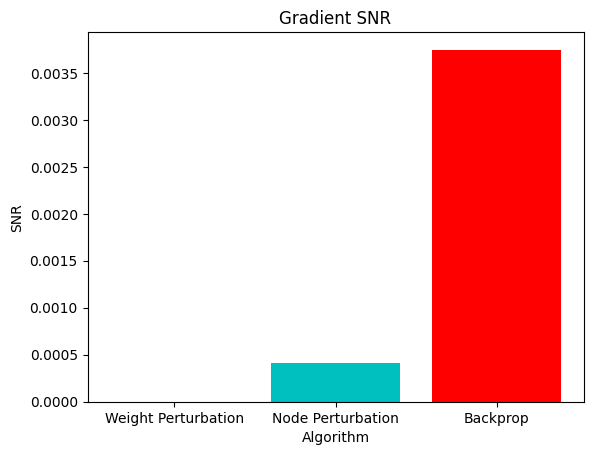

In [122]:
# Step 3:
# plot the SNR for the three learning algorithms
plt.figure()
x = [0, 1, 2]
snr_vals = [snr_weight_perturbation_solution, snr_node_perturbation_solution, snr_backpropagation_solution]
colors = ['b', 'c', 'r']
labels = ['Weight Perturbation', 'Node Perturbation', 'Backprop']
plt.bar(x, snr_vals, color=colors, tick_label=labels)
plt.xticks()
plt.ylabel('SNR')
plt.xlabel('Algorithm')
plt.title('Gradient SNR')
plt.savefig('images/gradient_snr.png')
plt.show()

##### 3.3.2 Cosine Similarity between backpropagation, feedback alignment, and Kolen-Pollack (3 points)

Having implemented both Feedback Alignment and Kolen-Pollack, we should now compare the parameter updates obtained by these algorithms to the Backpropagation update itself, so that we can assess how accurate these methods actually are.

To do this, we will measure the alignment between two gradient estimates using the cosine similarity, which is defined as follows, for two proposed parameter updates $\Delta \theta_1$ and $\Delta \theta_2$, which we assume are vectors of equal length:

$$
C Sim(\Delta \theta_1, \Delta \theta_2) = \frac{\Delta \theta_1^T \Delta \theta_2}{\|\Delta \theta_1\|_2 \|\Delta \theta_2\|_2}
$$

Below, we show the cosine similarity between backpropagation, feedback alignment, and Kolen-Pollack, all compared to the backpropagation algorithm itself. The backpropagation-to-backpropagation cosine similarity will always be 1, because the vectors trivially point in the same direction.

In [105]:
# define hyperparameters
numhidden  = 500
batchsize  = 200
initweight = 0.1
learnrate  = 0.001
noise      = 0.1
numepochs  = 4
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report     = True
rep_rate   = 1
seed = 12345

In [106]:
_, _, cosine_similarity_feedback_alignment_solution, _ = train_mlp(FeedbackAlignmentMLP, algorithm='feedback')

# code for node perturbation
_, _, cosine_similarity_kolen_pollack_solution, _ = train_mlp(KolenPollackMLP, algorithm='kolepoll')

# code for backpropagation
_, _, cosine_similarity_backpropagation_solution, _ = train_mlp(MLP, algorithm='backprop')

Training feedback starting...
Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.59 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.41 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.33 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.29 .
Training complete.
Training kolepoll starting...
Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.57 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.38 .
iterations:  550

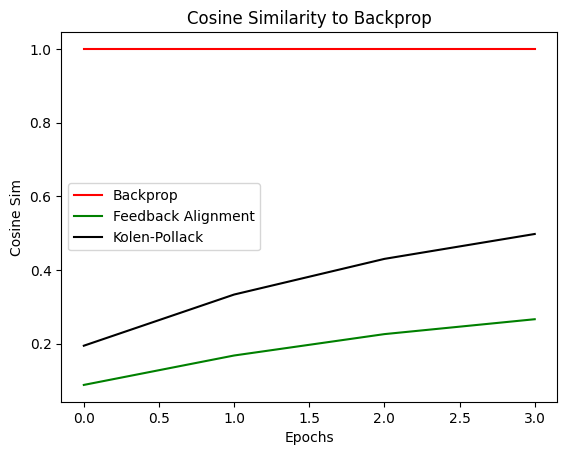

In [118]:
# Step 3:
# Plot the gradient similarity to backpropagation over training
plt.plot(cosine_similarity_backpropagation_solution, label="Backprop", color='r')
plt.plot(cosine_similarity_feedback_alignment_solution, label="Feedback Alignment", color='g')
plt.plot(cosine_similarity_kolen_pollack_solution, label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("Cosine Sim")
plt.legend()
plt.title("Cosine Similarity to Backprop")
plt.savefig('images/cosine_similarity.png')
plt.show()

#### 3.4 Randomness of matrix $\mathbf{B}$ in Feedback Alignment (3 points)

When training `FeedbackAlignmentMLP`, we use same seed value 12345 for all random variables. **Only change** the randomness of matrix $\mathbf{B}$ during initialization inside the `MLP` class (e.g., create a new saparate `rng` for $\mathbf{B}$) and see how it affect the training loss of the `FeedbackAlignmentMLP` model.

In [111]:
def train_feedback_alignment_vary_B(seeds):
    # Try different seeds to get a different random B matrix and plot the results
    losses = []
    accuracy = []
    cosine_similarity = []
    snr = []

    # set the random seed
    rng_np = np.random.default_rng(seed=12345)

    # select 1000 random images to test the accuracy on
    indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)
    for b_seed in seeds:
        print(f"Using seed {b_seed}")
        rng_b = np.random.default_rng(seed=b_seed)
        # create a network and train it using weight perturbation
        mlp_net = FeedbackAlignmentMLP(rng_np, numhidden, sigma=initweight, activation=activation)
        mlp_net.B = rng_b.normal(scale=mlp_net.sigma, size=(mlp_net.N, 10))  # feedback weights

        (curr_loss, curr_accuracy, curr_cosine_sim, curr_snr) = \
            mlp_net.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                                learning_rate=learnrate, batch_size=batchsize, algorithm='feedback', noise=noise, \
                                report=report, report_rate=rep_rate)

        losses.append(curr_loss); accuracy.append(curr_accuracy); cosine_similarity.append(curr_cosine_sim); snr.append(curr_snr);

    return losses, accuracy, cosine_similarity, snr

In [112]:
# Train FeedbackAlignmentMLP with different B matrices
seeds = [54321, 98765, 13579, 24680, 87654]

losses, accuracy, cosine_similarity, snr = train_feedback_alignment_vary_B(seeds)

Using seed 54321
Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.59 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.42 .
iterations:  550
iterations:  600
iterations:  650
iterations:  700
iterations:  750
...completed  3  epochs of training. Current loss:  0.34 .
iterations:  800
iterations:  850
iterations:  900
iterations:  950
iterations:  1000
...completed  4  epochs of training. Current loss:  0.3 .
Training complete.
Using seed 98765
Training starting...
iterations:  50
iterations:  100
iterations:  150
iterations:  200
iterations:  250
...completed  1  epochs of training. Current loss:  0.61 .
iterations:  300
iterations:  350
iterations:  400
iterations:  450
iterations:  500
...completed  2  epochs of training. Current loss:  0.45 .
iterations:  550
iterations:  600
iteration

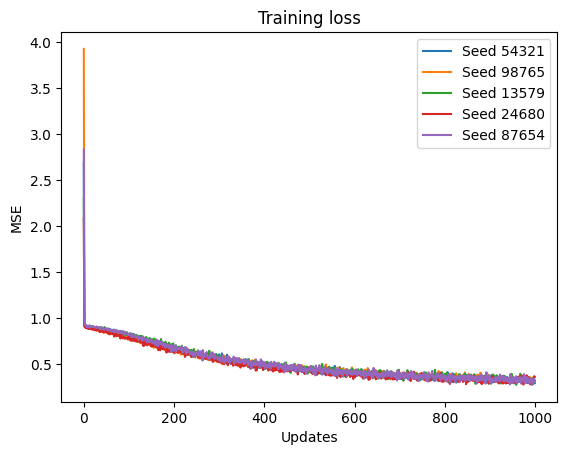

In [116]:
for i, seed in enumerate(seeds):
    plt.plot(losses[i], label=f"Seed {seed}")

plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.savefig("images/feedback_alignment_vary_B_loss.png")
plt.show()


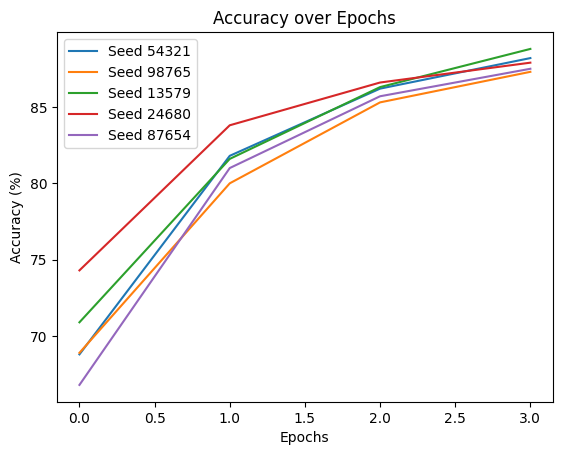

In [117]:
for i, seed in enumerate(seeds):
    plt.plot(accuracy[i], label=f"Seed {seed}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy over Epochs")
plt.savefig("images/feedback_alignment_vary_B_accuracy.png")
plt.show()